In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import torch 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from astropy.io import fits
from matplotlib import pyplot as plt

import seaborn as sns

device=torch.device(0 if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)


cuda:0


In [2]:
N_FIGS = 9 

Data = torch.load('./catalog/dr17_mastar.pt',map_location=device)
#Data = torch.load('./catalog/dr17_PCA.pt',map_location=device)
#Data = torch.load('./catalog/dr17_firefly_.pt',map_location=device)
Data[:,8,:,:] = Data[:,8,:,:]#+np.log10(1/0.25)
Data_firefly = torch.load('./catalog/dr17_new_mass.pt',map_location=device)
PCA_VT = torch.load('./catalog/PCA.pt',map_location=device)
#Data[:,6,:,:] = Data[:,7,:,:].clone()
#Data = torch.load('./catalog/data_100_dered_nsa.pt',map_location=device)
#Data = Data[:,[1,3,4,5],:,:]
#Data_ori = torch.load('./catalog/dr17_ori.pt',map_location=device)
#id_list = np.loadtxt('./catalog/dr17_all_id.txt',dtype=np.object)[:,0]
id_list = np.loadtxt('./catalog/dr17_id.txt',dtype=str)
test_id = id_list[int(0.8*len(Data)):]
NSAid_list = np.loadtxt('./NSAid_list.txt').astype(int)

train_set = Data[:int(0.7*len(Data)),:,:,:].to(device)
valid_set = Data[int(0.7*len(Data)):int(0.8*len(Data)),:,:,:].to(device)
test_set = Data[int(0.8*len(Data)):,:,:,:].to(device)

In [6]:
print(test_set.shape)

torch.Size([1653, 9, 100, 100])


In [3]:
hdulInfo = fits.open('./manga-firefly-v3_1_1-mastar.fits')
hdulLink = fits.open('MaNGA_targets_extNSA_tiled_ancillary.fits')
hduDRP = fits.open('./drpall-v3_1_1.fits')
hduNSA = fits.open('nsa_v1_0_1.fits')
#hdulpipe3d = fits.open('./SDSS17Pipe3D_v3_1_1.fits')


Coordata = hdulInfo[1].data
Regiondata = hdulInfo[4].data
Bindata = hdulInfo[5].data
Massdata = hdulInfo[11].data
Linkdata = hdulLink[1].data
NSA_data = hduNSA[1].data
DRPdata = hduDRP[1].data

def galaxy_idx_search(manga_id, mode):
    idx = []
    if mode == 'firefly':
        for i in range(galaxy_count):
            if Coordata[i][0] == manga_id:
                #print(i)
                idx.append(i)
                
    if mode == 'DRP':
        for i in range(0,len(DRPdata)):
            if DRPdata[i]['mangaid'] == manga_id:
                idx.append(i)
                
    if mode == 'NSA':
        for i in range(0,len(hdulLink[1].data)):
            if hdulLink[1].data[i]['mangaid'] == manga_id:
                idx.append(hdulLink[1].data['NSA_NSAID'][i])
    return idx

In [19]:
E_F = hduNSA[1].data['ELPETRO_FLUX'][NSAid_list][:,2:]
IV = hduNSA[1].data['ELPETRO_FLUX_IVAR'][NSAid_list][:,2:]
print(E_F[0])
print(IV[0])
print(np.sqrt(IV[0])*E_F[0])

[  84.83465  460.82535  957.3652  1369.7349  1769.767  ]
[0.00957758 0.45003468 0.17848964 0.05380388 0.00517065]
[  8.302354 309.14294  404.46796  317.7191   127.25911 ]


In [4]:
def Conv2D(in_channels,out_channels,kernel_size,padding):
    conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=1, padding = padding),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
    return conv

class CNN(nn.Module):
    mass_std = 2.0667
    mass_mean = 3.5082

    photo_std = 0.8338
    photo_mean = 1.4620
    
    def __init__(self, in_chan=5 , mid=64 , out = 1,
                kernel_size = 5,
                n_layers  =3):
        padding = int(kernel_size/2)
        super(CNN, self).__init__()
        self.redshift = Conv2D(6,6,1,0)
        self.conv_1 =Conv2D(in_chan,mid,kernel_size,padding = padding)
        conv = []
        #self.norm = nn.BatchNorm2d(3)
        for i in range(0,n_layers-1):
            conv.append(
                nn.Conv2d(in_channels = mid, out_channels = mid, kernel_size = kernel_size, stride=1, padding = padding),
            )
            conv.append(nn.ReLU())
            #conv.append(nn.BatchNorm2d(mid))
        self.conv = nn.Sequential(*conv)
        self.conv_f1 =Conv2D(mid,int(mid/2),kernel_size,padding = padding)
        self.conv_f2 =Conv2D(int(mid/2),out,kernel_size,padding = padding)
        #self.conv_f3 =Conv2D(out,out,1,padding = 0)
    def forward(self, x):
        img = torch.clone(x[:,:6,:,:])
        img[:,5,:,:]*=100
        VT = torch.clone(x[:,6:,:,:])
        #img = self.redshift(img)#*0.1+img[:,:5,:,:]
        
        x_ = torch.cat([img,VT],dim=1).clone()
        x_ = self.conv_1(x_)
        x_ = self.conv(x_)
        x_ = self.conv_f1(x_)
        x_ = self.conv_f2(x_)
        #x_ = 0.1*self.conv_f3(x_)+x_
        #x_ = x_*filter
        return x_, torch.log10(torch.sum(10**x_))

In [4]:
# g-r model

def Conv2D(in_channels,out_channels,kernel_size,padding):
    conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=1, padding = padding),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
    return conv

class CNN_noVT(nn.Module):
    mass_std = 2.0667
    mass_mean = 3.5082

    photo_std = 0.8338
    photo_mean = 1.4620
    
    def __init__(self, in_chan=5 , mid=64 , out = 1,
                kernel_size = 5,
                n_layers  =3):
        padding = int(kernel_size/2)
        super(CNN_noVT, self).__init__()
        self.redshift = Conv2D(6,6,1,0)
        self.conv_1 =Conv2D(in_chan-1,mid,kernel_size,padding = padding)
        conv = []
        #self.norm = nn.BatchNorm2d(3)
        for i in range(0,n_layers-1):
            conv.append(
                nn.Conv2d(in_channels = mid, out_channels = mid, kernel_size = kernel_size, stride=1, padding = padding),
            )
            conv.append(nn.ReLU())
            #conv.append(nn.BatchNorm2d(mid))
        self.conv = nn.Sequential(*conv)
        self.conv_f1 =Conv2D(mid,int(mid/2),kernel_size,padding = padding)
        self.conv_f2 =Conv2D(int(mid/2),out,kernel_size,padding = padding)
        #self.conv_f3 =Conv2D(out,out,1,padding = 0)
    def forward(self, x):
        #img = torch.clone(x[:,:6,:,:])
        #img[:,5,:,:]*=100
        img = torch.cat([x[:,1:3,:,:],x[:,5:6,:,:]],dim = 1)
        img[:,2,:,:]*=100
        VT = torch.clone(x[:,7:,:,:])
        #img = self.redshift(img)#*0.1+img[:,:5,:,:]
        
        x_ = torch.cat([img,VT],dim=1).clone()
        x_ = self.conv_1(x_)
        x_ = self.conv(x_)
        x_ = self.conv_f1(x_)
        x_ = self.conv_f2(x_)#-np.log10(0.25)
        #x_ = 0.1*self.conv_f3(x_)+x_
        #x_ = x_*filter
        return x_, torch.log10(torch.sum(10**x_))  

In [3]:
def Conv2D(in_channels,out_channels,kernel_size,padding):
    conv = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=1, padding = padding),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2)
        )
    return conv

class CNN_noVT(nn.Module):
    mass_std = 2.0667
    mass_mean = 3.5082

    photo_std = 0.8338
    photo_mean = 1.4620
    
    def __init__(self, in_chan=5 , mid=64 , out = 1,
                kernel_size = 5,
                n_layers  =3):
        padding = int(kernel_size/2)
        super(CNN_noVT, self).__init__()
        self.redshift = Conv2D(6,6,1,0)
        self.conv_1 =Conv2D(in_chan-1,mid,kernel_size,padding = padding)
        conv = []
        #self.norm = nn.BatchNorm2d(3)
        for i in range(0,n_layers-1):
            conv.append(
                nn.Conv2d(in_channels = mid, out_channels = mid, kernel_size = kernel_size, stride=1, padding = padding),
            )
            conv.append(nn.ReLU())
            #conv.append(nn.BatchNorm2d(mid))
        self.conv = nn.Sequential(*conv)
        self.conv_f1 =Conv2D(mid,int(mid/2),kernel_size,padding = padding)
        self.conv_f2 =Conv2D(int(mid/2),out,kernel_size,padding = padding)
        #self.conv_f3 =Conv2D(out,out,1,padding = 0)
    def forward(self, x):
        img = torch.clone(x[:,:6,:,:])
        img[:,5,:,:]*=100
        VT = torch.clone(x[:,7:,:,:])
        #img = self.redshift(img)#*0.1+img[:,:5,:,:]
        
        x_ = torch.cat([img,VT],dim=1).clone()
        x_ = self.conv_1(x_)
        x_ = self.conv(x_)
        x_ = self.conv_f1(x_)
        x_ = self.conv_f2(x_)#-np.log10(0.25)
        #x_ = 0.1*self.conv_f3(x_)+x_
        #x_ = x_*filter
        return x_, torch.log10(torch.sum(10**x_))

In [4]:
model_name = 'Mastar'

#model = torch.load('./models/saved/model_100_masked_31.pt',map_location=device)
#model = torch.load('./models/models_dr17/PCA_noVT_136.pt',map_location=device)
#model = torch.load('./models/Firefly_noVT/Firefly_noVT_12.pt',map_location=device)
model = torch.load('./models/Firefly_Mastar_1/Firefly_Mastar_1_68.pt',map_location=device)
#model = torch.load('./models/Firefly_Mastar_gr/Firefly_Mastar_gr_46.pt',map_location=device)
#model = torch.load('./test.pt',map_location=device)
#model = torch.load('./dr17_new_40e.pt',map_location=device)

In [21]:
for name, parameters in model.named_parameters():
    print(name, ':', parameters.size())

redshift.0.weight : torch.Size([6, 6, 1, 1])
redshift.0.bias : torch.Size([6])
conv_1.0.weight : torch.Size([35, 7, 11, 11])
conv_1.0.bias : torch.Size([35])
conv.0.weight : torch.Size([35, 35, 11, 11])
conv.0.bias : torch.Size([35])
conv.2.weight : torch.Size([35, 35, 11, 11])
conv.2.bias : torch.Size([35])
conv_f1.0.weight : torch.Size([17, 35, 11, 11])
conv_f1.0.bias : torch.Size([17])
conv_f2.0.weight : torch.Size([1, 17, 11, 11])
conv_f2.0.bias : torch.Size([1])


In [27]:
class CNN_result():
    def __init__(self,model, index, mode='test',data=Data):
        self.model = model
        self.index = index
        self.mode = mode
        if mode == 'all':
            self.manga_id = id_list[index]
            self.x = data[index:(index+1),:,:,:]

        if mode == 'test':
            test_set = data[int(0.8*len(Data)):,:,:,:].to(device)
            self.manga_id = test_id[index]
            self.x= (test_set[index:(index+1),:,:,:].clone())
        
    def get_img(self, mode):
        temp = self.x[:,:(N_FIGS-1),:,:]
        if mode == 'pred':
            img = (self.model(temp)[0]*self.x[:,(N_FIGS-2):(N_FIGS-1),:,:]).to('cpu').detach().numpy()
        if mode == 'truth':
            img = self.x[:,(N_FIGS-1):,:,:].to('cpu').detach().numpy()

        return img[0][0]
    
    def VT_bined(self, _image):
        #hdu_bin = fits.open('./MaNGA_train/bin_id/'+str(self.manga_id)+'_bin_id.fits',dtype=np.float32)
        #bin_id = torch.tensor(hdu_bin[0].data.astype(np.float32)).reshape([1,1,100,100])
        bin_id = self.bin_id.ravel()
        #bin_id = bin_id[scramble_idx]
        bin_id = bin_id.numpy()
        bin_count = np.unique(bin_id, return_counts = True)[1]
        bin_inverse = np.unique(bin_id, return_inverse = True)[1]
        image_1d = _image.ravel()
        image_VT = np.zeros([len(bin_id)])
        for i in range(len(bin_count)):
            _sum = np.sum(10**image_1d[bin_inverse==i])
            image_VT[bin_inverse==i]=np.log10(_sum/bin_count[i])
        image_VT = image_VT.reshape(_image.shape)
        return image_VT
    
    def VT_lize(self, do_scramble = False):
        temp = self.x
        #temp[:,:3,:,:] = (temp[:,:3,:,:])*test_set[index:(index+1),4:5,:,:] #overall 
        #temp[:,0,:,:] = (temp[:,0,:,:]+0)*test_set[index:(index+1),(N_FIGS-2),:,:] #g band
        #temp[:,1,:,:] = (temp[:,1,:,:]+0)*test_set[index:(index+1),(N_FIGS-2),:,:] #r band
        #temp[:,2,:,:] = (temp[:,2,:,:]+0.5)*test_set[index:(index+1),(N_FIGS-2),:,:] #i band
        temp[:,5,:,:] = (temp[:,5,:,:])
        temp[:,:5,:,:] = temp[:,:5,:,:]*test_set[self.index:(self.index+1),(N_FIGS-2),:,:]-10*(1-test_set[self.index:(self.index+1),(N_FIGS-2),:,:])
        
        hdu_bin = fits.open('./MaNGA_train/bin_id/'+str(self.manga_id)+'_bin_id.fits',dtype=np.float32)
        self.bin_id = torch.tensor(hdu_bin[0].data.astype(np.float32)).reshape([1,1,100,100])
        if do_scramble:
            self.bin_id = self.scramble(self.bin_id) #scramble the VT_bin
            temp = self.scramble(temp, keep=1).to(device)  #scramble the data
        mass_tru = self.get_img('truth')
        self.mass_pred = self.get_img('pred')
        
        mass_pred_VT = self.VT_bined(self.mass_pred)
        mass_tru[mass_tru<-10]=0
        self.mass_tru = self.VT_bined(mass_tru)
        mass_pred_VT = mass_pred_VT.reshape(self.mass_pred.shape)
        #mass_pred_VT = mass_pred_VT-(-0.1*mass_pred_VT+0.82)
        self.mass_pred_VT = mass_pred_VT*temp[0,(N_FIGS-2),:,:].to('cpu').detach().numpy()
        return self.mass_pred_VT, self.mass_tru, self.manga_id

    def total_mass(self):
        mass_pred_VT = torch.tensor(10**self.mass_pred_VT)
        mass_pred_VT[mass_pred_VT==1] = 0
        gmass_pred = torch.sum(0.16*mass_pred_VT)

        mass_tru = torch.tensor(10**self.mass_tru)
        mass_tru[mass_tru==1] = 0
        gmass_tru = torch.sum(0.16*mass_tru)

        return gmass_pred, gmass_tru

    def scramble(self,temp,keep = 0):
        mask = self.x[:,(N_FIGS-2),:,:].to('cpu').bool().numpy().ravel()
        scramble = torch.ones(temp.shape)
        for idx in range(temp.shape[1]):
            map = temp[:,idx,:,:].ravel()
            if not keep:
                self.scramble_idx = torch.randperm(len(map[mask]))
            map[mask] = map[mask][self.scramble_idx]
            scramble[:,idx,:,:] = map.reshape(temp[:,idx,:,:].shape)
        return scramble
    
    def Gaussian(self, k_size=5, sigma = 2.5):
        for i in range(0,5):
            self.x[0,i:(i+1),:,:] = torch.tensor(self._gauss(self.x[0,i,:,:].to('cpu').numpy(), k_size, sigma))
    
    def _gauss(self, temp, kernel_size = 5, sigma=2.5):
        def gaussian_kernel(size, sigma):
            x, y = np.meshgrid(np.arange(-size // 2 + 1, size // 2 + 1), np.arange(-size // 2 + 1, size // 2 + 1))
            kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
            return kernel / np.sum(kernel)
        gaussian_filter = gaussian_kernel(kernel_size, sigma)
        result = convolve(10**temp, gaussian_filter,mode='nearest')
        return np.log10(result)

def M_L(bands, a, b):
    #print(bands[0]-bands[1])
    return a+b*(bands[0]-bands[1])

def bands(index, band):
    bands =  Data[int(len(Data)*0.8)+i,(band[0],band[1]),:,:].to('cpu').detach().numpy()
    bands = (10**bands).sum(axis=(1,2))
    bands = np.log10(bands)
    return bands

def p90_pred(index):
    manga_id = test_id[index]
    f_name = './Data/p90_image/'+manga_id+'.fits'
    hdulp90 = fits.open(f_name)
    image = hdulp90[0].data
    image[:,:,:,:5][image[:,:,:,:5]<=0]=10**-10
    image[:,:,:,:5] = np.log10(image[:,:,:,:5])
    redshift = test_set[index,5,:,:].max()

    p90_sam = np.zeros([1,8,len(image[0]),len(image[0])])
    for i in range(0,5):
        p90_sam[0,i,:,:] = image[0,:,:,i]*image[0,:,:,5]
    p90_sam[0,5,:,:] = np.ones([len(image[0]),len(image[0])])*redshift.to('cpu').numpy()
    p90_sam[0,7,:,:] = image[0,:,:,5]

    p90_sam = p90_sam.astype(np.float32)
    p90_tsam = torch.tensor(p90_sam).to(device)

    p90_pixel, p90_total = model(p90_tsam)
    p90_pixel = p90_pixel.to('cpu').detach().numpy()
    #plt.imshow(p90_pixel[0,0])
    return p90_pixel, p90_total.to('cpu').detach().numpy()+np.log10(0.16), image

def nsa_read(index, item = 'ELPETRO_FLUX'):
    manga_id = test_id[index]
    NSA_id = NSAid_list[index]
    mag = NSA_data[item][NSA_id]
    #print(mag)
    return mag

In [35]:
indices = np.searchsorted(NSA_data['NSAID'], NSAid_list)
NSAid_list_ = indices

In [7]:
mass = []
for index in range(0,len(test_set)):
    try:
        _, p90_mass, p90_image = p90_pred(index)
        #mag = np.log10((10**p90_image[0]).sum(axis=(0,1)))
        mag  = nsa_read(index, item = 'ELPETRO_ABSMAG')
        mag -= 5*np.log10(0.7)
        lum_s = 10**(0.4*(4.85-mag))

        bell_ml = M_L(mag[3:5], -0.306, 1.097)#+mag[4]+9
        #print(10**bell_ml)
        bell_mass = np.log10(lum_s)[5]+bell_ml
        #print(p90_mass, bell_mass)

            #result = CNN_result(model,index)
            #result.Gaussian(k_size=50, sigma=25)
            #result.VT_lize()
        mass.append([p90_mass, bell_mass])
        if index%100 == 0:
            print(index)
    except:
        continue
    
mass = np.array(mass)
print(mass)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
[[ 9.98401004  9.97469103]
 [10.07954246 10.12035194]
 [11.49321681 11.36609386]
 ...
 [10.9050315  10.66735206]
 [10.95111877 10.84736441]
 [ 8.50593311  8.5565734 ]]


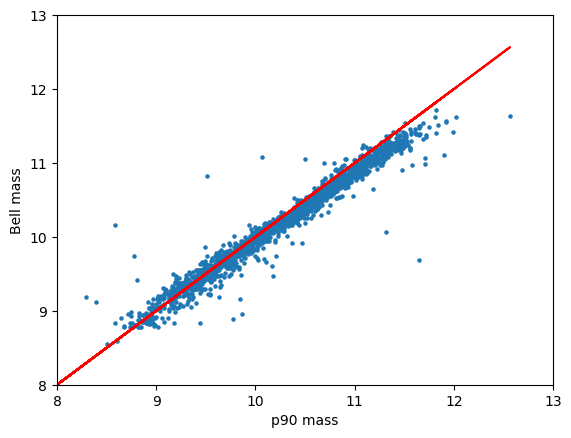

In [8]:
mass = np.array(mass)
plt.plot(mass[:,0], mass[:,0], color='red')
plt.scatter(mass[:,0], mass[:,1],s=5)
plt.xlim(8,13)
plt.ylim(8,13)
plt.xlabel('p90 mass')
plt.ylabel('Bell mass')
plt.show()

In [58]:
PCA_mass = []
for i in range(0, len(test_set)):    
    PCA_mass.append(0.25*(10**Data_PCA[i,0,:,:].to('cpu').detach().numpy()).sum())
PCA_mass[PCA_mass==0]=1
gmass[gmass==0]=1

In [6]:
def sampling(model, if_scramble = False, full_scramble = False, para = []):
    mode = 'test'
    where_ctr = test_set[:,(N_FIGS-3):(N_FIGS-2),:,:].bool().reshape([len(test_set),10000]).to('cpu')
    gmass = []
    bin_num = []
    VT_diff = []
    # int(len(test_set))
    for i in range(0, int(len(test_set))):
        result = CNN_result(model,i)
        if if_scramble:
            result.Gaussian(k_size=para[1], sigma=para[0])
        result.VT_lize(do_scramble = full_scramble)

        r_img = result.x[0,2,:,:].to('cpu').detach().numpy()
        M_L_r = M_L(result.x[0,(1,2),:,:].to('cpu').detach().numpy(), -0.306, 1.097)
        bell_mass = result.VT_bined(M_L_r+r_img+9)

        gmass.append([result.total_mass()[0],result.total_mass()[1],(10**bell_mass).sum()*0.16])
        VT_ctr = test_set[i,6,:,:].to('cpu').detach().numpy()
        bin_num.append(np.sum(VT_ctr))

        pred_1d = torch.tensor(result.mass_pred_VT.ravel())
        truth_1d = torch.tensor(result.mass_tru.ravel())
        bell_1d  = torch.tensor(bell_mass.ravel())
        if not i:
            all_pred =  pred_1d[where_ctr[i]]
            all_truth = truth_1d[where_ctr[i]]
            all_bell = bell_1d[where_ctr[i]]
        else:
            all_pred = torch.cat([all_pred,pred_1d[where_ctr[i]]])
            all_truth = torch.cat([all_truth,truth_1d[where_ctr[i]]])
            all_bell = torch.cat([all_bell,bell_1d[where_ctr[i]]])

        VT_tru = truth_1d[where_ctr[i]]
        VT_pred = pred_1d[where_ctr[i]]
        VT_diff_temp = pred_1d[where_ctr[i]]-truth_1d[where_ctr[i]]
        VT_diff_std ,VT_diff_mean = torch.std_mean(VT_diff_temp)
        VT_diff.append([(10**VT_tru).mean(), (10**VT_pred).mean(),VT_diff_mean.numpy(), VT_diff_std.numpy()])
        #if i%200 ==0:
            #print(i)

    #gmass[gmass==0]=1

    gmass = np.array(gmass)
    gmass = gmass.reshape([len(gmass),3])
    bad = np.argwhere(gmass[:,0]==0).ravel()
    bin_num = np.array(bin_num)
    bin_num = bin_num.ravel()
    VT_diff = np.array(VT_diff)
    VT_diff[bad] = 0
    print(i)
    print(torch.std_mean(all_pred-all_truth))
    print()
    return all_truth, all_pred, gmass, VT_diff

In [28]:
all_truth, all_pred, gmass, VT_diff = sampling(model, full_scramble = True)
all_truth_, all_pred_, gmass_, VT_diff_ = sampling(model, full_scramble = False)

/tmp/ipykernel_4440/509756310.py:37: UserWarning: std_mean(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  VT_diff_std ,VT_diff_mean = torch.std_mean(VT_diff_temp)


1652
(tensor(0.6833, dtype=torch.float64), tensor(0.0733, dtype=torch.float64))

1652
(tensor(0.3973, dtype=torch.float64), tensor(0.0300, dtype=torch.float64))



tensor([], dtype=torch.int64)
-0.04816087923702823 0.8275284860564319
[-0.12214896  0.03272035  0.19675796]
[-0.38232917  0.03272035  0.41910584]


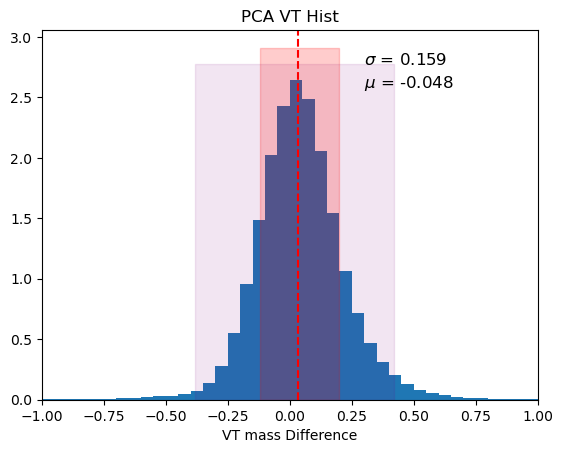

In [9]:
bad = np.argwhere(all_pred==0).ravel()
print(bad)
gmass_diff = (all_truth-all_pred).numpy()
#gmass_diff[bad] = 0
one_sig = np.percentile(gmass_diff,[16,50,84])
two_sig = np.percentile(gmass_diff,[2.5,50,97.5])
print(np.mean(gmass_diff),np.std(gmass_diff))
print(one_sig)
print(two_sig)
plt.hist(gmass_diff,bins=40,density=True, range = [-1,1])
#sns.kdeplot(gmass_diff,bw_adjust=0.4)
height  = plt.gca().get_ylim()[1]
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], two_sig[0], two_sig[2], alpha=0.1, color='purple')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], one_sig[0], one_sig[2], alpha=0.2, color='r')
plt.axvline(one_sig[1], color='r', linestyle='--')
plt.xlabel('VT mass Difference')
#plt.ylim(0,1.2)
plt.title(model_name+' VT Hist')
plt.text(0.3,height,'$\sigma$ = %.3f'% ((one_sig[2]-one_sig[0])/2), fontsize = 12)
plt.text(0.3,0.93*height,'$\mu$ = %.3f'% (np.mean(gmass_diff)), fontsize = 12)
plt.xlim(-1,1)
plt.savefig('./Analyses/'+model_name+'_VT.pdf',dpi=400)
plt.show()


[ 114  150  365  437 1059 1429 1613]
0.03867047386826743 0.7625831569362206
[-0.13395288 -0.03001741  0.05897241]
[-0.24893611 -0.03001741  0.16800055]


/tmp/ipykernel_32678/1629394609.py:3: RuntimeWarning: divide by zero encountered in log10
  gmass_diff = np.log10(gmass[:,0])-np.log10(gmass[:,1])


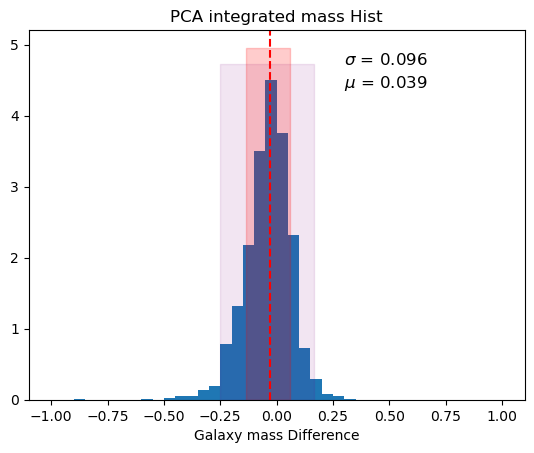

In [10]:
bad = np.argwhere(gmass[:,0]==0).ravel()
print(bad)
gmass_diff = np.log10(gmass[:,0])-np.log10(gmass[:,1])
gmass_diff[bad] = 0
one_sig = np.percentile(gmass_diff,[16,50,84])
two_sig = np.percentile(gmass_diff,[2.5,50,97.5])
print(np.mean(gmass_diff),np.std(gmass_diff))
print(one_sig)
print(two_sig)
plt.hist(gmass_diff,bins=40,density=True, range = [-1,1])
#sns.kdeplot(gmass_diff,bw_adjust=0.4)
height  = plt.gca().get_ylim()[1]
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], two_sig[0], two_sig[2], alpha=0.1, color='purple')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], one_sig[0], one_sig[2], alpha=0.2, color='r')
plt.axvline(one_sig[1], color='r', linestyle='--')
plt.xlabel('Galaxy mass Difference')
#plt.ylim(0,1.2)
plt.title(model_name+' integrated mass Hist')
plt.text(0.3,height,'$\sigma$ = %.3f'% ((one_sig[2]-one_sig[0])/2), fontsize = 12)
plt.text(0.3,0.93*height,'$\mu$ = %.3f'% (np.mean(gmass_diff)), fontsize = 12)

#plt.xlim(-1,1)
plt.savefig('./Analyses/'+model_name+'_gmass.pdf',dpi=400)
plt.show()


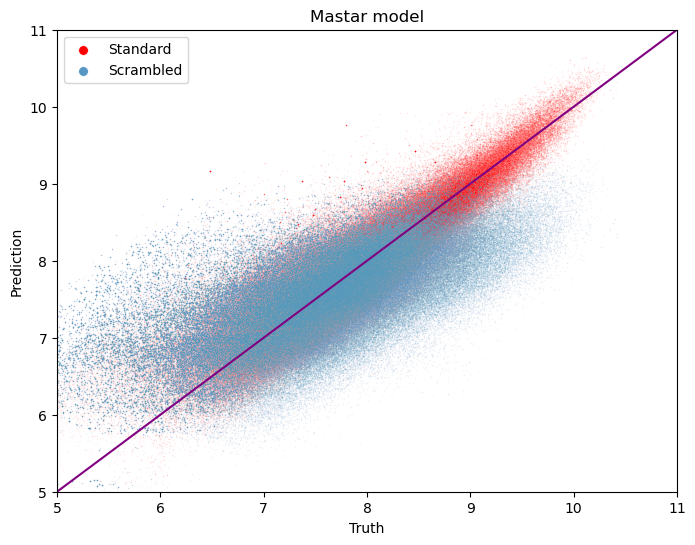

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data
plt.rcParams['axes.facecolor'] = 'white' #'#EEF7F2'

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Scatter plots for 'Galaxy mass' and 'VT cell mass'
sns.scatterplot(x=all_truth_,y=all_pred_, color='red', s = 1,alpha=0.05)
sns.scatterplot(x=all_truth,y=all_pred, color='#5698C3', s = 1,alpha=0.1)

#sns.scatterplot(x=np.log10(gmass[:,1]), y=np.log10(gmass[:,0]), color='red', s= 5,alpha=0.5)
sns.scatterplot(x=[0], y=[0], color='red', label='Standard',s= 50,alpha= 1 )
sns.scatterplot(x=[0],y=[0], color='#5698C3', label='Scrambled', s = 50, alpha= 1)

#sns.scatterplot(x=np.log10(VT_diff[:, 0]), y=np.log10(VT_diff[:, 1]), color='red', label='Mean VT mass for each galaxy',s= 3,alpha=0.7)
# Add the y=x line
x = np.linspace(4,12,20)
sns.lineplot(x=x, y=x, color='purple', linestyle='-')

# Add labels and title
plt.xlim(5,11)
plt.ylim(5,11)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.legend(loc='upper left')
plt.title(model_name+' model')

plt.savefig('./Analyses/Scramble_or_not.png',dpi=400)
# Show the plot
plt.show()


/tmp/ipykernel_12620/715390299.py:37: UserWarning: std_mean(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  VT_diff_std ,VT_diff_mean = torch.std_mean(VT_diff_temp)


1652
(tensor(0.3973, dtype=torch.float64), tensor(0.0300, dtype=torch.float64))

[ 114  150  365  437 1059 1429 1613]
0.030027140500621198 0.3973484087820941
[-0.27549324 -0.01451851  0.31116977]
[-0.53706093 -0.01451851  0.87041574]
1652
(tensor(0.4331, dtype=torch.float64), tensor(-0.1093, dtype=torch.float64))

[ 114  150  365  437 1059 1429 1613]
-0.10932297249238176 0.43305578952219465
[-0.4699748  -0.13465696  0.22138833]
[-0.80553448 -0.13465696  0.77151972]
1652
(tensor(0.4210, dtype=torch.float64), tensor(-0.0789, dtype=torch.float64))

[ 114  150  365  437 1059 1429 1613]
-0.07893116118278226 0.420950758931397
[-0.4221201  -0.10592236  0.23200955]
[-0.74371258 -0.10592236  0.78807714]
1652
(tensor(0.4353, dtype=torch.float64), tensor(-0.0804, dtype=torch.float64))

[ 114  150  365  437 1059 1429 1613]
-0.08037819719374227 0.4353356577881908
[-0.44244821 -0.11066733  0.24600759]
[-0.75491561 -0.11066733  0.81615428]
1652
(tensor(0.5026, dtype=torch.float64), tensor(-0.1786, dt

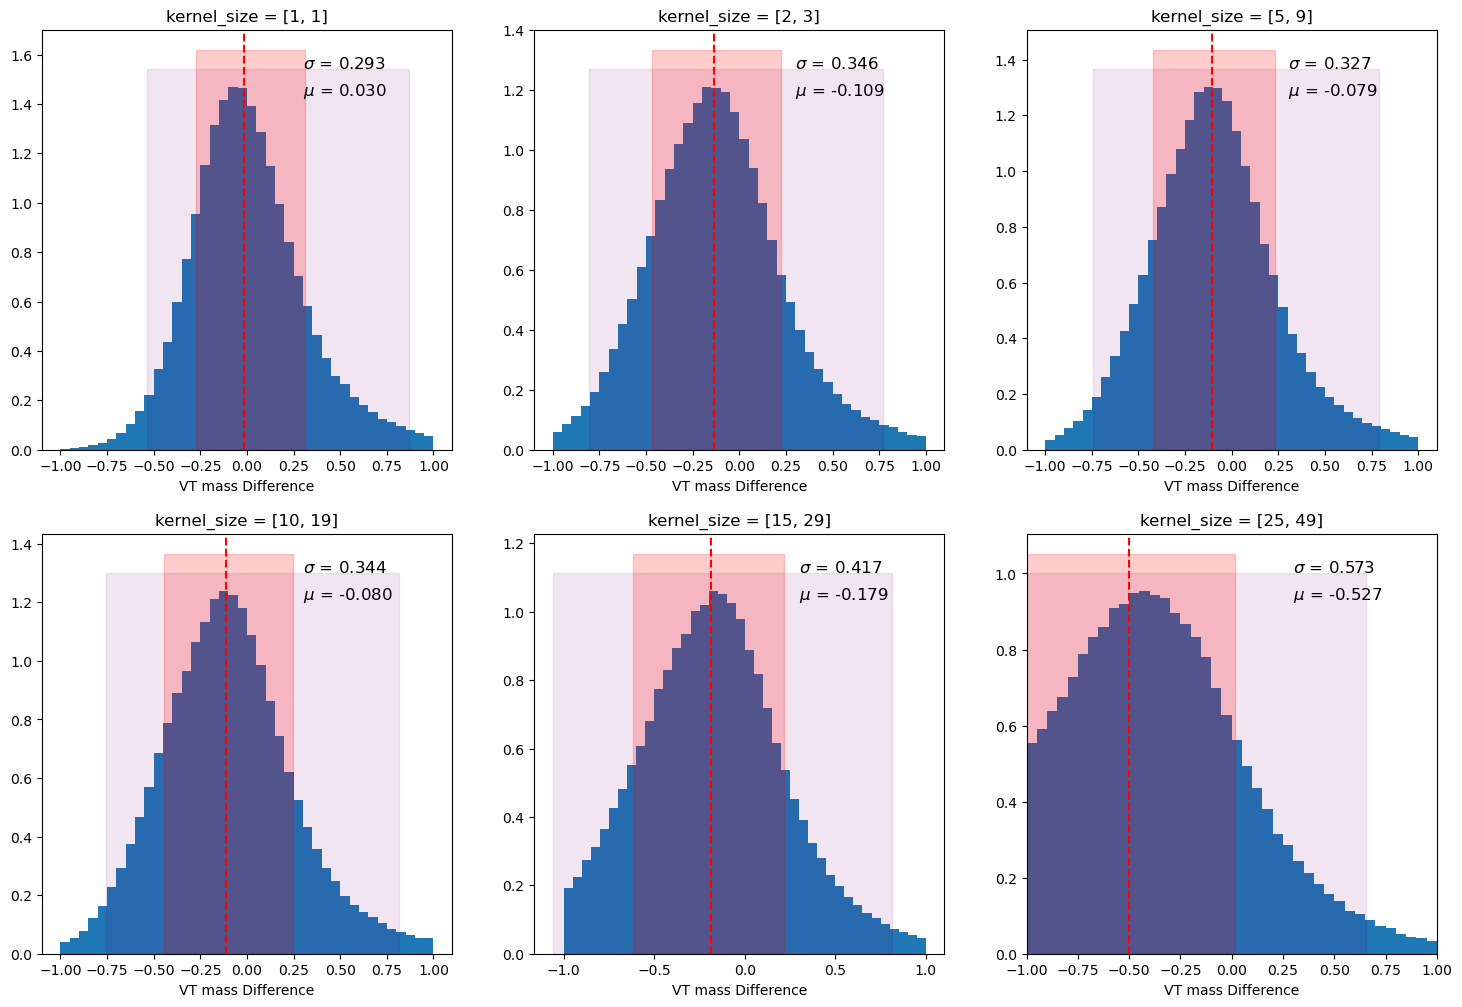

In [8]:
# Scramble Plot
kernel_list = [[1,1],[2,3],[5,9], [10,19], [15,29], [25,49]]
plt.figure(figsize=(18,12))
for index in range(0,6):
    all_truth, all_pred, gmass, VT_diff = sampling(model, if_scramble = True, para = kernel_list[index])
    plt.subplot(2,3,index+1)
    
    bad = np.argwhere(gmass[:,0]==0).ravel()
    print(bad)
    #gmass_diff = np.log10(gmass[:,0])-np.log10(gmass[:,1])
    gmass_diff = (all_pred-all_truth).numpy()
    #gmass_diff[bad] = 0
    one_sig = np.percentile(gmass_diff,[16,50,84])
    two_sig = np.percentile(gmass_diff,[2.5,50,97.5])
    print(np.mean(gmass_diff),np.std(gmass_diff))
    print(one_sig)
    print(two_sig)
    plt.hist(gmass_diff,bins=40,density=True, range = [-1,1])
    #sns.kdeplot(gmass_diff,bw_adjust=0.4)
    height  = plt.gca().get_ylim()[1]
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], two_sig[0], two_sig[2], alpha=0.1, color='purple')
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], one_sig[0], one_sig[2], alpha=0.2, color='r')
    plt.axvline(one_sig[1], color='r', linestyle='--')
    plt.xlabel('VT mass Difference')
    #plt.ylim(0,1.2)
    plt.title('kernel_size = ['+ str(kernel_list[index][0])+', '+str(kernel_list[index][1])+']')
    plt.text(0.3,height,'$\sigma$ = %.3f'% ((one_sig[2]-one_sig[0])/2), fontsize = 12)
    plt.text(0.3,0.93*height,'$\mu$ = %.3f'% (np.mean(gmass_diff)), fontsize = 12)

plt.xlim(-1,1)
plt.savefig('./Analyses/Scramble_VT.pdf',dpi=400)
plt.show()

/tmp/ipykernel_9728/55740212.py:16: RuntimeWarning: divide by zero encountered in log10
  sns.scatterplot(x=np.log10(gmass[:,1]), y=np.log10(gmass[:,2])-0.15, color='red', label='galaxy',s= 5,alpha=0.5)


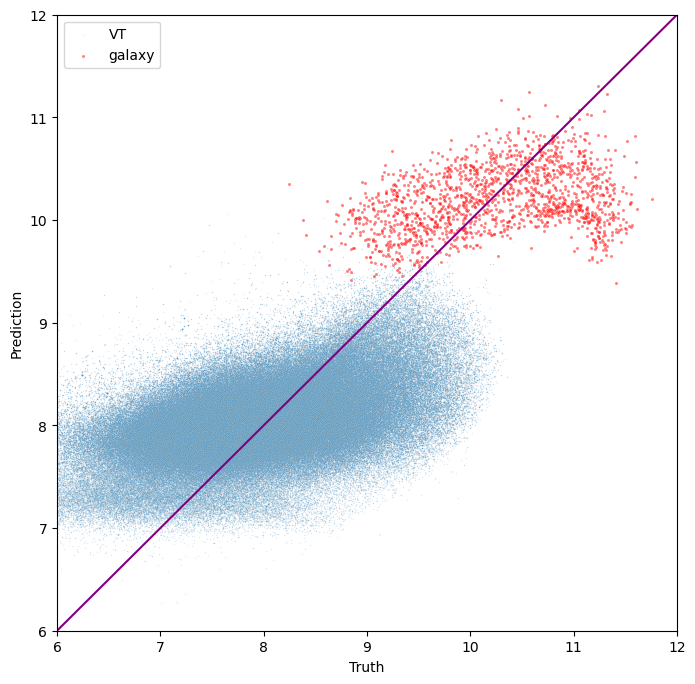

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data
plt.rcParams['axes.facecolor'] = 'white' #'#EEF7F2'

# Create the scatter plot using seaborn
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

#plt.subplot(121)
# Scatter plots for 'Galaxy mass' and 'VT cell mass'

#sns.scatterplot(x=all_truth,y=all_PCA, color='#5698C3', label='PCA', s = 1,alpha=0.2)
sns.scatterplot(x=all_truth,y=all_bell-0.15, color='#5698C3', label='VT', s = 1,alpha=0.2)
sns.scatterplot(x=np.log10(gmass[:,1]), y=np.log10(gmass[:,2])-0.15, color='red', label='galaxy',s= 5,alpha=0.5)

#sns.scatterplot(x=np.log10(VT_diff[:, 0]), y=np.log10(VT_diff[:, 1]), color='red', label='Mean VT mass for each galaxy',s= 3,alpha=0.7)
# Add the y=x line
x = np.linspace(4,12,20)
sns.lineplot(x=x, y=x, color='purple', linestyle='-')

# Add labels and title
plt.xlim(6,12)
plt.ylim(6,12)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.legend(loc='upper left')
#plt.title('Scrambled result for VT mass')

'''plt.subplot(122)
#sns.scatterplot(x=np.log10(gmass[:,1]), y=np.log10(PCA_mass), color='#5698C3', label='PCA',s= 5,alpha=0.7)
sns.scatterplot(x=np.log10(gmass[:,1]), y=np.log10(gmass[:,0]), color='red', label='CNN model',s= 5,alpha=0.5)

# Add the y=x line
x = np.linspace(4,12,20)
sns.lineplot(x=x, y=x, color='purple', linestyle='-')

# Add labels and title
plt.xlim(6,12)
plt.ylim(6,12)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.legend(loc='upper left')'''


#plt.savefig('./Analyses/scrambled_VT.png',dpi=400)
# Show the plot
plt.show()


9.062038429432615
tensor(11.4796, dtype=torch.float64) tensor(11.2028, dtype=torch.float64)


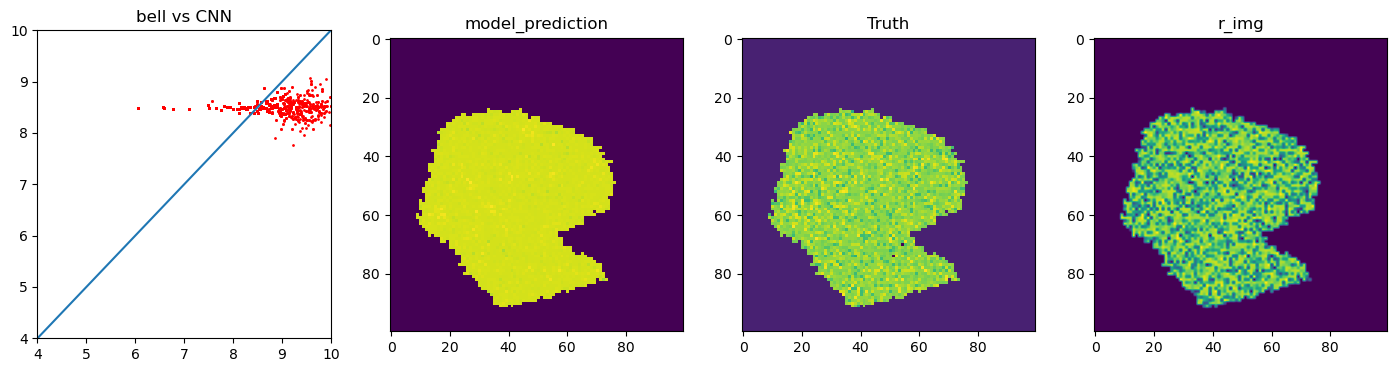

In [26]:
mode = 'test'
#where_ctr = test_set[:,(N_FIGS-3):(N_FIGS-2),:,:].bool().reshape([len(test_set),10000]).to('cpu')
for i in range(2,3):
    result = CNN_result(model,i, mode)
    #mass_pred = result.get_img('pred')
    mass_pred_VT, mass_tru, manga_id = result.VT_lize(do_scramble  = True)
    r_img = result.x[0,2,:,:].to('cpu').detach().numpy()
    M_L_r = M_L(result.x[0,(1,2),:,:].to('cpu').detach().numpy(), -0.306, 1.097)
    print(mass_pred_VT.max())
    print(torch.log10(result.total_mass()[1]),torch.log10(result.total_mass()[0]))

    
    #result_ = CNN_result(model,i, mode,data = Data_firefly)
    #mass_firefly = result_.VT_lize()[1]
    
    fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,4))
    
    x = np.linspace(4,10,10)
    #axes[0].scatter(mass_tru.ravel(),mass_pred_VT.ravel(),s=1,color = 'red')
    axes[0].scatter(mass_tru.ravel(),mass_pred_VT.ravel(),s=1,color = 'red')
    #axes[0].scatter(mass_tru.ravel(),bell_mass.ravel(), s=1,color = 'blue')
    axes[0].plot(x,x)
    axes[0].set_xlim(4,10)
    axes[0].set_ylim(4,10)
    axes[0].title.set_text('bell vs CNN')
    

    
    #plt.subplot(132)
    axes[1].imshow(mass_pred_VT,interpolation='none')
    axes[1].title.set_text('model_prediction')
    
    #plt.subplot(133)
    axes[2].imshow(mass_tru,interpolation='none')
    axes[2].title.set_text('Truth')
    
    
    #r_img = Data[int(len(Data)*0.8)+i,2,:,:].to('cpu').detach().numpy()
    axes[3].imshow(r_img)
    axes[3].title.set_text('r_img')
    #plt.savefig('./new_image/dr12_good_'+str(manga_id)+'.png')
    fig.subplots_adjust(right=0.8)
    plt.show()

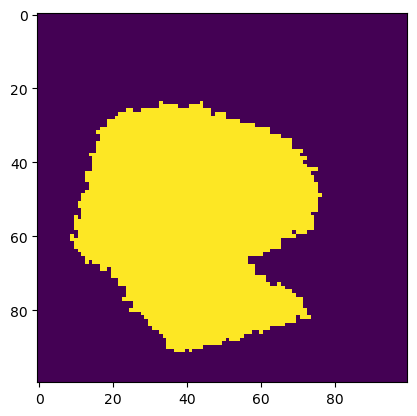

In [52]:
plt.imshow(result.x[0,7,:,:].to('cpu').detach().numpy())